In [69]:

R = 20
L = 100
r_normalized = R/ L


# solve the min for N/log N>= r**2
def min_N_for_r(r):
    from math import log
    from scipy.optimize import fsolve

    def equation(N):
        return N / log(N) - 2/r**2

    # Initial guess for N
    initial_guess = 1000
    N_solution = fsolve(equation, initial_guess)[0]
    
    return int(N_solution)

min_N = min_N_for_r(r_normalized)
print(f"Minimum N for r={r_normalized:.4f} is {min_N}")


Minimum N for r=0.2000 is 282


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

In [3]:
N = 200
R = 15
L = 100

# random generate points uniformly in a square
points = np.random.uniform(0, L, size=(N, 2))
# check connectivity
G = nx.Graph()
G.add_nodes_from(range(N))
# add edges based on distance
for i in range(N):
    for j in range(i + 1, N):
        if np.linalg.norm(points[i] - points[j]) <= R:
            G.add_edge(i, j)

# check if connected
is_connected = nx.is_connected(G)
print(f"Graph is connected: {is_connected}")





Graph is connected: True


(0.0, 100.0)

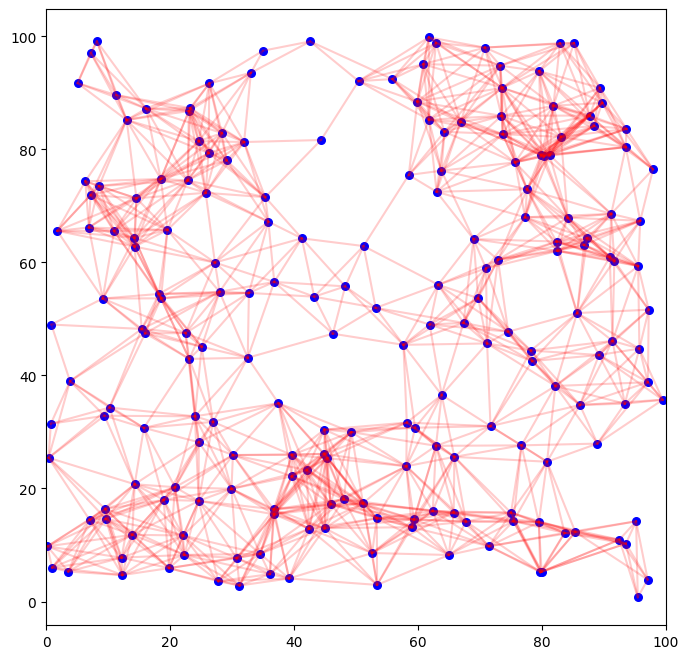

In [4]:
# plot the graph in right location
plt.figure(figsize=(8, 8))
plt.scatter(points[:, 0], points[:, 1], s=30, color='blue', label='Nodes')
for edge in G.edges():
    plt.plot(*zip(points[edge[0]], points[edge[1]]), color='red', alpha=0.2)
plt.xlim(0, L)


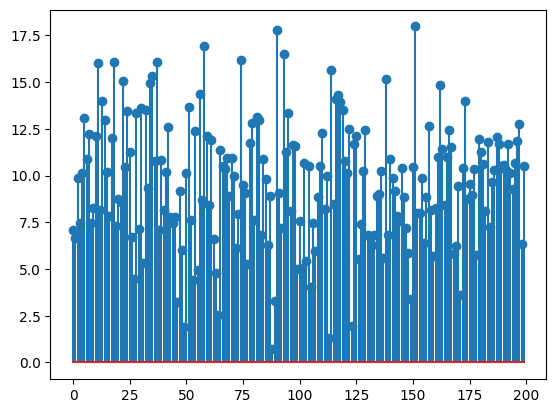

In [5]:
MAX_ITERS = int(2e5)
x_gt = 10 # ground truth value
x_cov = 10 # covariance of the noise
x_init = (x_gt + np.random.randn(N)*np.sqrt(x_cov)).reshape(N, 1) # initial obs

plt.stem(x_init)

mu_x = x_init.mean()
mu_x_1 = np.ones((N,1)) * mu_x # x mean times ones vector


random_gossip

In [6]:
neigh_list = {i: list(G.neighbors(i)) for i in G.nodes}
# Pre‑compute neighbour probabilities p_{ij}=1/deg(i)
neigh_probs = {i: [1/len(list(G.neighbors(i)))]*len(list(G.neighbors(i)))
               for i in G.nodes}

A = nx.adjacency_matrix(G).todense()
deg = A.sum(axis=1)  
# neigh_probs = neigh_probs * A
P = A / deg[:, None]         

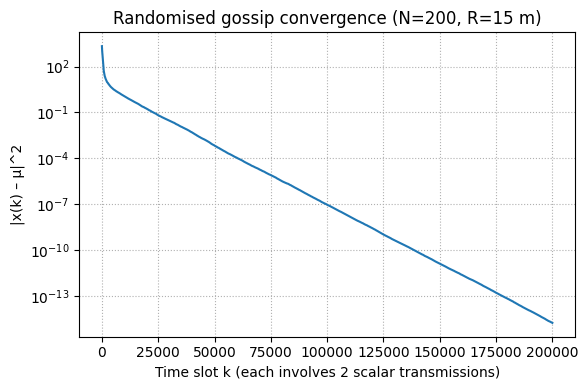

In [7]:
x = x_init.copy()            # initial state

# ---------------- randomised gossip simulation ----------------
errors = []            # mean absolute error after each time slot
for k in range(MAX_ITERS):
    # record error *before* update
    errors.append(np.linalg.norm(x - mu_x_1)**2)

    # pick node i uniformly, then neighbour j with prob p_{ij}
    i = random.randrange(N)
    j = random.choices(neigh_list[i], weights=neigh_probs[i])[0]

    avg = 0.5 * (x[i] + x[j])
    x[i] = avg
    x[j] = avg


# ---------------- plot error vs. time slots (iterations) ----------------
plt.figure(figsize=(6,4))
plt.semilogy(errors, linewidth=1.5)
plt.xlabel("Time slot k (each involves 2 scalar transmissions)")
plt.ylabel("|x(k) – μ|^2")
plt.title("Randomised gossip convergence (N=200, R=15 m)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


In [ ]:
def pdmm_average(
        x_init,        
        a,              
        G,               
        c=1.0,        
        max_iters=int(1e4)
    ):

    x = x_init.copy().astype(float)
    n = len(x)
    deg = np.array([G.degree[i] for i in range(n)])


    edges_dir = [(i, j) for i, j in G.edges()] + [(j, i) for i, j in G.edges()]
    z = {e: 0.0 for e in edges_dir}

    mu = a.mean()
    errors = []
    transmissions = []
    m_dir = len(edges_dir)              

    for k in range(max_iters):
        
        for i in range(n):
            s = sum(z[(i, j)] for j in G.neighbors(i))
            x[i] = (a[i] - s) / (1.0 + c * deg[i])


        errors.append(np.linalg.norm(x - mu) ** 2)



        y = {e: z[e] + 2.0 * c * x[e[0]] for e in edges_dir}
        for i, j in edges_dir:
            z[(j, i)] = -y[(i, j)]

        transmissions.append(transmissions[-1] + m_dir if transmissions else m_dir)

    return errors, transmissions


In [9]:
pdmm_err, pdmm_tx = pdmm_average(x_init, x_init, G, c=0.35, max_iters=int(2e2))

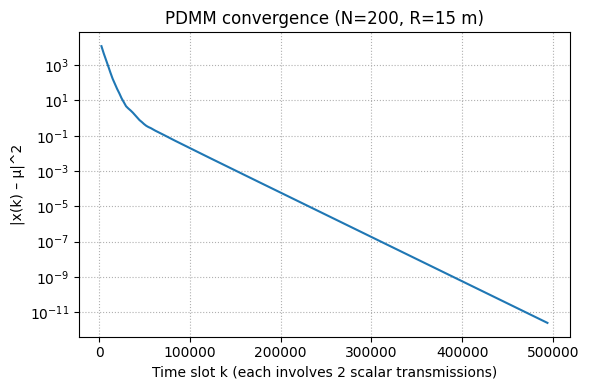

In [10]:
# ---------------- plot error vs. time slots (iterations) ----------------
plt.figure(figsize=(6,4))
plt.semilogy(pdmm_tx, pdmm_err, label='PDMM', linewidth=1.5)
plt.xlabel("Time slot k (each involves 2 scalar transmissions)")
plt.ylabel("|x(k) – μ|^2")
plt.title("PDMM convergence (N=200, R=15 m)")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()

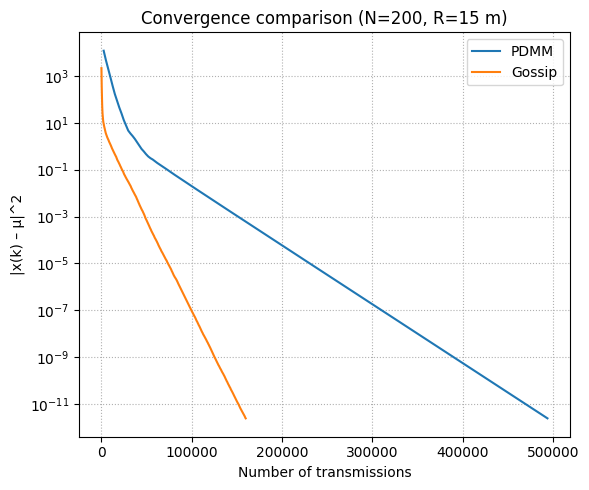

In [11]:
# adjust y to plot them together
max_err = max(min(pdmm_err), min(errors))
# max_err float64 of 1e-10
# max_err = np.float64(1e-12)  # ensure it's a float for plotting

# plot range for pdmm
pdmm_idx = np.where(pdmm_err <= max_err)[0][0]
gossip_idx = np.where(errors   <= max_err)[0][0]
gossip_cum_tx = np.arange(len(errors)) * 2
# plot PDMM and gossip together
plt.figure(figsize=(6,5))
plt.semilogy(pdmm_tx[:pdmm_idx+1], pdmm_err[:pdmm_idx+1], label='PDMM', linewidth=1.5)
plt.semilogy(errors[:gossip_idx+1], label='Gossip', linewidth=1.5)
# plt.semilogy(gossip_cum_tx[:gossip_idx+1],errors[:gossip_idx+1], label='Gossip', linewidth=1.5)
plt.xlabel("Number of transmissions")
plt.ylabel("|x(k) – μ|^2")
plt.title("Convergence comparison (N=200, R=15 m)")
plt.tight_layout()
plt.grid(True, which="both", linestyle=":")
plt.legend()

In [62]:
import numpy as np
import networkx as nx
from tqdm import tqdm
def pdmm_median(
        x_init,     
        a,          
        G,    
        c=1.0,          
        max_iters=int(1e4)
    ):
    """
    Returns
    -------
    errors        : list[float] -- squared 2-norm  ||x(k) – median(a)||²
    transmissions : list[int]   -- cumulative scalar messages
    x             : np.ndarray  -- final node values
    """
    # ---------- initialisation -------------------------------------------
    x   = x_init.copy().astype(float)
    n   = len(x)
    deg = np.array([G.degree[i] for i in range(n)], dtype=float)

    edges_dir = [(i, j) for i, j in G.edges()] + [(j, i) for i, j in G.edges()]
    z = {e: 0.0 for e in edges_dir}
    per_iter_tx = len(edges_dir)          # 2 · |E| scalars per PDMM sweep

    target_med = float(np.median(a))
    errors, transmissions = [], []

    # ---------- main loop -------------------------------------------------
    bar = tqdm(range(max_iters), desc="PDMM Median", unit="iter", leave=False)
    
    
    # c_init = c
    # c_last = c_init * 10
    # c_scale = np.exp(np.log(c_last / c_init) / max_iters)  # exponential scaling
    # for _ in range(max_iters):
    for k in bar:
        # ----- 1) x-update --------------------------------------------------
        for i in range(n):
            # if k>= max_iters // 2:
            #     c = c+0.1
            S  = sum(z[(i, j)] for j in G.neighbors(i))
            cd = c * deg[i] 

            x_plus  = -(S + 1.0) / cd
            x_minus = -(S - 1.0) / cd

            if x_plus > a[i]:
                x[i] = x_plus
            elif x_minus < a[i]:
                x[i] = x_minus
            else:
                x[i] = a[i]

        # ----- 2) metrics ---------------------------------------------------
        errors.append(float(np.linalg.norm(x - target_med) ** 2))

        # ----- 3) y / z updates & messaging --------------------------------
        y = {e: z[e] + 2.0 * c * x[e[0]] for e in edges_dir}
        for i, j in edges_dir:
            z[(j, i)] = -y[(i, j)]

        transmissions.append(
            transmissions[-1] + per_iter_tx if transmissions else per_iter_tx
        )

        # progress-bar diagnostics every 100 iters
        if k % 10 == 0:
            bar.set_postfix(
                error  = f"{errors[-1]:.4e}",
                mean_x = f"{x.mean():.4f}",
                std_x  = f"{x.std():.4f}",
                median = f"{target_med:.4f}"
            )
    return errors, transmissions, x


In [63]:
a = x_init.copy()  # fixed observations
med_err, med_tx, x_pdmm_med = pdmm_median(x_init, a, G, c=20)
# print(f"Final PDMM median: {x_pdmm_med.mean():.4f} (target median: {float(np.median(a)):.4f})")

In [54]:
x_pdmm_med

array([[9.86365924],
       [9.86475461],
       [9.86691859],
       [9.86073197],
       [9.85906458],
       [9.86127119],
       [9.86045558],
       [9.86045259],
       [9.85886088],
       [9.86164136],
       [9.86446866],
       [9.86540376],
       [9.85870903],
       [9.86298961],
       [9.86308546],
       [9.86431459],
       [9.8664563 ],
       [9.86781521],
       [9.86656255],
       [9.86594533],
       [9.86447093],
       [9.86650999],
       [9.86185488],
       [9.86150939],
       [9.86429536],
       [9.86045259],
       [9.86368161],
       [9.85631856],
       [9.86306362],
       [9.86707983],
       [9.86375518],
       [9.86563097],
       [9.86764075],
       [9.86454416],
       [9.865408  ],
       [9.86382401],
       [9.8637825 ],
       [9.86207476],
       [9.8720562 ],
       [9.86347069],
       [9.85920044],
       [9.86175444],
       [9.86559206],
       [9.8656409 ],
       [9.86110729],
       [9.86675929],
       [9.85977158],
       [9.864

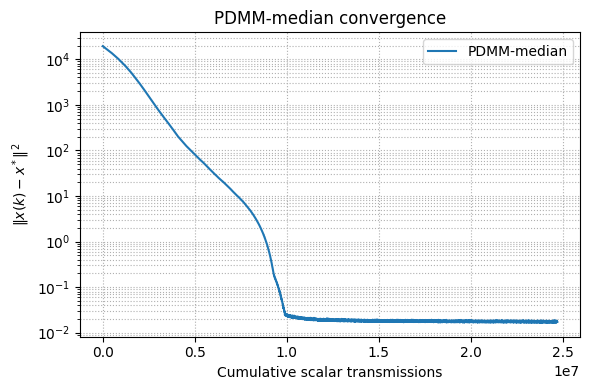

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.semilogy(med_tx, med_err, lw=1.5, label="PDMM-median")
plt.xlabel("Cumulative scalar transmissions")
plt.ylabel(r"$\|x(k)-x^*\|^2$")
plt.title("PDMM-median convergence")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout(); plt.legend(); plt.show()
